In [0]:
#dependencies
!pip install Pillow==4.1.1
!pip3 install torch torchvision
!pip install PIL
!pip install image
import torch
import torch.nn as nn
import cv2
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

    100% |████████████████████████████████| 5.7MB 6.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 591.8MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x620bc000 @  0x7fd4953062a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 17.3MB/s 
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [ ]:
#uploading images to colab
from google.colab import files
files.upload()

In [8]:
import os
print(os.listdir('/content'))

['.config', 'content.jpg', 'style.jpg', 'sample_data']


In [0]:
#loading image
style_image = Image.open('/content/style.jpg')
content_image = Image.open('/content/content.jpg')

In [0]:
imsize  =256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor(), # transform it into a torch tensor
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])#normalize image 


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/style.jpg")
content_img = image_loader("/content/content.jpg")
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [0]:
#content loss
def content_loss(content,output):
  return F.mse_loss(content,output)

#gram matrix
# d --> Depth
# h --> height of image
# width --> width of image

def gram_matrix(input):
  _,d,h,w = input.size()
  features = input.view(d, h * w)
  gram = torch.mm(features, features.t()) #features.t() for taking transpose of array
  return gram
def style_loss(style,output):
  s = gram_matrix(style)
  o = gram_matrix(output)
  return F.mse_loss(s,o)


In [0]:
#load vgg19 conv layers and freeze the parameters
model = models.vgg19(pretrained = True).features #pretrained for taking weights of pretrained network and features will get output as only convolution layer
# freezing parameters
for parameter in model.parameters():
  parameter.requires_grad_(False)

In [0]:
#getting features for content and style from vgg conv layer
def get_features(image,model,layer= None):
  model.to(device)
  if layer is None:
    layer = {'0','5','10','19','21','28'} #layers to extract features mentioned in paper for best results
  features = {} #empty list to include feature arrays of image
  x = image
  for name,layers in model._modules.items():
    x = layers(x)
    if name in layer:
      features[name] = x 
  return features


In [0]:
content_features = get_features(content_img,model,{'21'})
style_features = get_features(style_img,model)
#get gram matrix for these features
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
#creating target image and setting required grad true 
target = content_img.clone().requires_grad_(True).to(device)


In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'0': 1.,
                 '5': 0.75,
                 '10': 0.2,
                 '19': 0.2,
                 '28': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  395717.09375


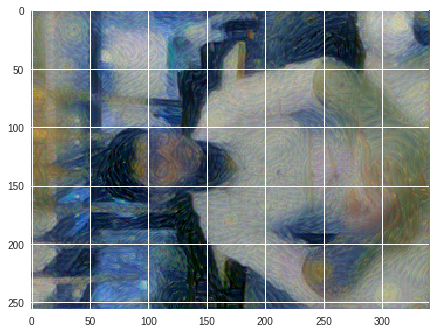

In [0]:
optimizer = optim.Adam([target], lr=0.003)
show_every = 400
epochs = 2000
for i in range(1,epochs+1):
    
    target_features = get_features(target, model)
    
    # the content loss
    content_loss = torch.mean((target_features['21'] - content_features['21'])**2)
    
    # the style loss
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()